In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LinearRegression
data = pd.read_csv("sacrifices-clean.csv")

Let's have a look at a summary for each column:

In [2]:
data["item"].value_counts()

Ring         127
Amulet       112
Pendant      108
Warhammer     78
Sword         74
Longsword     71
Battleaxe     66
Saw           64
Axe           53
Plough        47
Hammer        36
Name: item, dtype: int64

<AxesSubplot:>

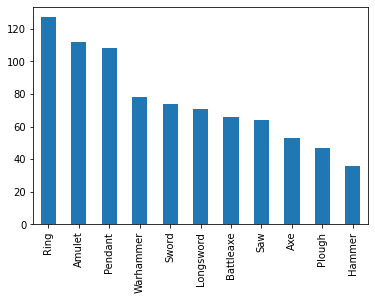

In [3]:
data["item"].value_counts().plot.bar()

In [4]:
data["enchant"].value_counts()

Rage           68
Power          68
Plenty         68
Industry       68
Prosperity     67
Flame          65
Capability     62
Wrath          61
Wounding       60
Glory          51
Justice        50
Abstraction    26
Hope           21
Protection     21
Beauty         20
Winter         16
Joy            16
Melancholy     14
Truth          14
Name: enchant, dtype: int64

<AxesSubplot:>

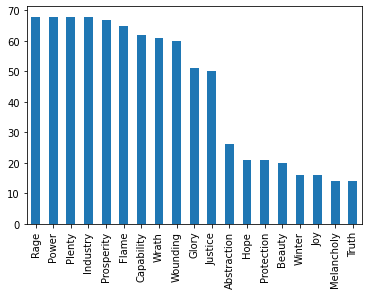

In [5]:
data["enchant"].value_counts().plot.bar()

In [6]:
data["mod"].value_counts()

0    390
1    130
2    111
3     70
4     68
5     34
6     31
7      1
8      1
Name: mod, dtype: int64

<AxesSubplot:>

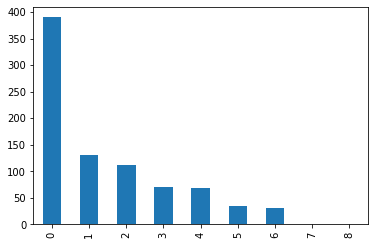

In [7]:
data["mod"].value_counts().plot.bar()

In [8]:
data["color"].value_counts()

blue      284
yellow    214
green     197
red       141
Name: color, dtype: int64

<AxesSubplot:>

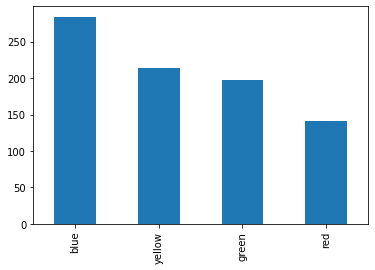

In [9]:
data["color"].value_counts().plot.bar()

In [10]:
data[["thmm", "mana"]].describe()

,thmm,mana
count,836.000000,836.000000
mean,27.958134,20.514354
std,18.136724,14.098746
min,1.000000,1.000000
25%,12.000000,10.000000
50%,27.000000,19.000000
75%,40.000000,24.000000
max,83.000000,96.000000


<AxesSubplot:>

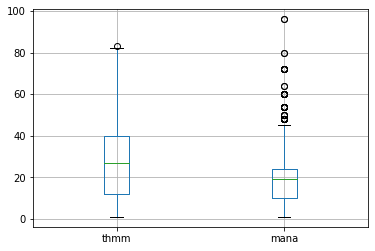

In [11]:
data[["thmm", "mana"]].boxplot()

Items seem to concentrate at low mana (75th percentile is 24 mana), but there are some crazy-high mana items out there. Let's take a look at the full distribution.

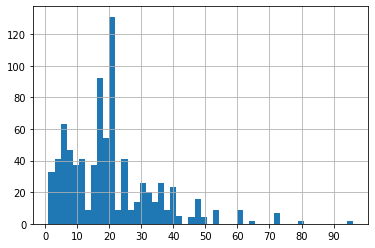

In [12]:
data["mana"].hist(bins=50).set_xticks(range(0,100,10))

Maybe it's just me, but there seem to be four groups:
- low valued items around 5 mana
- mid valued items around 20 mana
- high valued items around 35 mana
- a long tail of ludicrously powerful items

Maybe the long tail is not composed of just high valued items. If we had a small group of items uniformly distributed in the [0, 100] range it would _look_ like a long tail.

<AxesSubplot:>

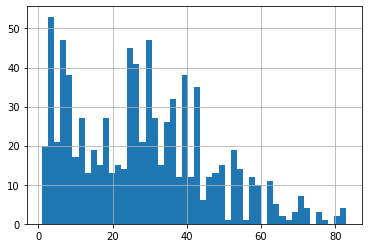

In [13]:
data["thmm"].hist(bins=50)

Thaumometer readings don't look like anything to me.

Let's look at the relationship between Thaumometer readings and Mana.

A thaumometer-mana scatterplot would have a lot of repeated readings and tightly-clustered readings, distorting our perception of hot spots. A hexbin splits the plane into areas and shows how many readings fell on each area.

<AxesSubplot:xlabel='thmm', ylabel='mana'>

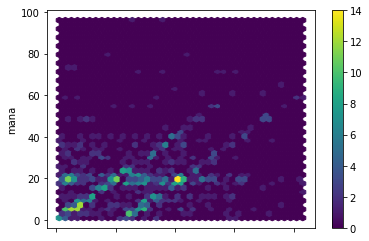

In [14]:
data.plot.hexbin(x="thmm", y="mana", gridsize=40, cmap="viridis")

There is a horizontal line around 20 mana, which tells us that the big spike we saw in the mana histogram is not being caught by the thaumometer. If the thaumometer _had_ caught that, we would see a bright spot at (20,20), instead of a line.

There is also two parallel diagonals. This tells us that some items are being overestimated a fixed amount. The diagonal that goes through (0,0) is the correct-calibration line. But i can't quite tell by eye if the line's slope is 45°.

In [15]:
data.groupby("color")["mana"].describe()

,count,mean,std,min,25%,50%,75%,max
color,,,,,,,,
blue,284.0,18.464789,15.146242,1.0,6.0,12.0,27.25,60.0
green,197.0,21.289340,11.332747,2.0,12.0,22.0,30.00,40.0
red,141.0,25.177305,22.515164,1.0,8.0,18.0,36.00,96.0
yellow,214.0,19.448598,1.168713,18.0,18.0,19.0,21.00,21.0


Yellow items are clustered _really_ tightly around 19 mana:
- standard deviation of just 1.2, vs 11, 15, and 16 for other groups
- all yellow items are between 18 and 21 mana

This is likely the middle group we saw on the histogram.

color
blue      AxesSubplot(0.125,0.125;0.62x0.755)
green     AxesSubplot(0.125,0.125;0.62x0.755)
red       AxesSubplot(0.125,0.125;0.62x0.755)
yellow    AxesSubplot(0.125,0.125;0.62x0.755)
dtype: object

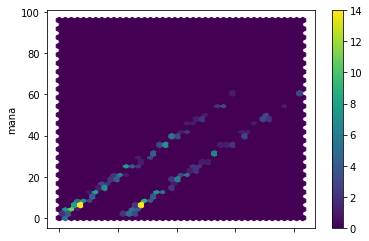

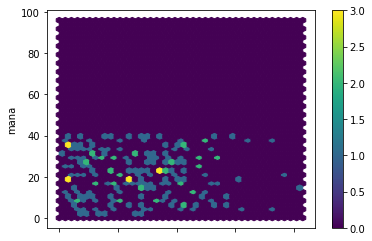

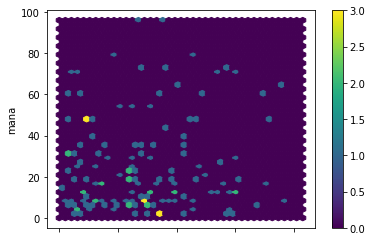

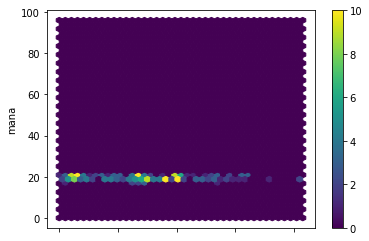

In [16]:
data.groupby("color").plot.hexbin(
    x="thmm",
    y="mana",
    gridsize=40,
    cmap="viridis",
    extent=[
        0, data["thmm"].max(),
        0, data["mana"].max()])

*Note: the above graph was updated to share x and y ranges.*

- blue items have a linear mana-thaumometer response, except for some items that are being overestimated by a consistent amount
- green items seem uncorrelated to the thaumometer
- red items seem uncorrelated to the thaumometer
- yellow items seem uncorrelated to the thaumometer, _and they fall on only four values_: 18, 19, 20, and 21

In [17]:
yellows = data[data["color"] == "yellow"]
yellows["mana"].value_counts()

18    61
21    58
19    54
20    41
Name: mana, dtype: int64

Let's sort out that double-diagonal business. Is there anything in the item name that can clue us in?

In [18]:
blues = data[data["color"] == "blue"]

In [19]:
blues.eval('error = thmm - mana').groupby("item")["error"].mean()

item
Amulet       22.000000
Axe           0.538462
Battleaxe     0.357143
Hammer        0.400000
Longsword     0.363636
Pendant      21.975610
Plough        0.375000
Ring         22.121951
Saw          -0.058824
Sword         0.000000
Warhammer     0.000000
Name: error, dtype: float64

Amulets, Pendants, and Rings are all overestimated by about 22 points. The Thaumometer likes jewelry; fabulous.

Let's adjust for that and see if the error is gone.

In [20]:
blues.eval('adj_thmm = thmm - 22*(item in ["Amulet", "Pendant", "Ring"])', inplace=True)

<AxesSubplot:xlabel='adj_thmm', ylabel='mana'>

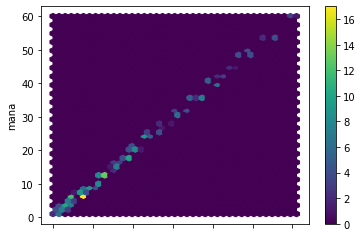

In [21]:
blues.plot.hexbin(x="adj_thmm", y="mana", gridsize=40, cmap="viridis")

Beautiful. Now the slope.

In [22]:
X = blues.loc[:, "adj_thmm"].values.reshape(-1, 1)
Y = blues.loc[:, "mana"].values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)

LinearRegression()

In [23]:
linear_regressor.coef_

array([[0.99880778]])

That's close enough to a 1 for me. How much error is there in our predictions?

In [24]:
blues.eval('error = adj_thmm - mana')["error"].describe()

count    284.000000
mean       0.133803
std        0.992757
min       -1.000000
25%       -1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: error, dtype: float64

**_Plus/minus 1._** Yeah, I'll take that.

In [25]:
from sklearn.metrics import r2_score
r2_score(Y, linear_regressor.predict(X))

0.9957052985495919

Can we tease out any relationship for greens and reds?

In [26]:
reds = data[data["color"] == "red"]

array([[<AxesSubplot:title={'center':'Amulet'}>,
        <AxesSubplot:title={'center':'Axe'}>,
        <AxesSubplot:title={'center':'Battleaxe'}>],
       [<AxesSubplot:title={'center':'Hammer'}>,
        <AxesSubplot:title={'center':'Longsword'}>,
        <AxesSubplot:title={'center':'Pendant'}>],
       [<AxesSubplot:title={'center':'Plough'}>,
        <AxesSubplot:title={'center':'Ring'}>,
        <AxesSubplot:title={'center':'Saw'}>],
       [<AxesSubplot:title={'center':'Sword'}>,
        <AxesSubplot:title={'center':'Warhammer'}>, <AxesSubplot:>]],
      dtype=object)

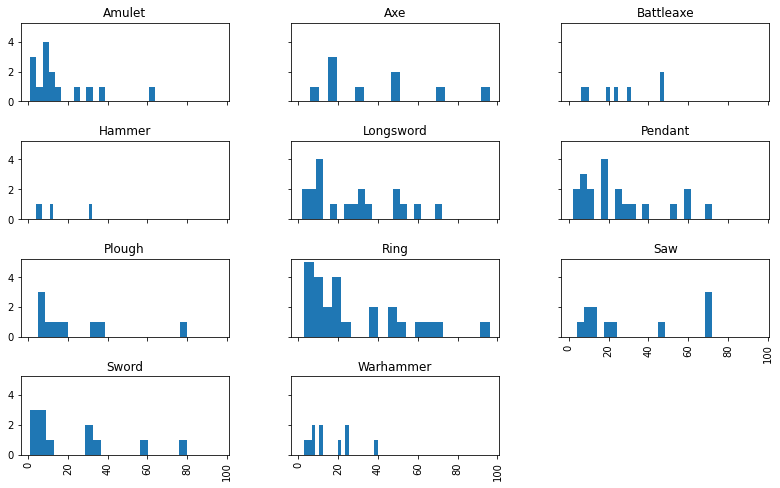

In [27]:
reds.hist(column="mana", by="item", figsize=(13,8), sharex=True, sharey=True, bins=20)

array([[<AxesSubplot:title={'center':'Abstraction'}>,
        <AxesSubplot:title={'center':'Beauty'}>,
        <AxesSubplot:title={'center':'Capability'}>,
        <AxesSubplot:title={'center':'Flame'}>],
       [<AxesSubplot:title={'center':'Glory'}>,
        <AxesSubplot:title={'center':'Hope'}>,
        <AxesSubplot:title={'center':'Industry'}>,
        <AxesSubplot:title={'center':'Justice'}>],
       [<AxesSubplot:title={'center':'Melancholy'}>,
        <AxesSubplot:title={'center':'Plenty'}>,
        <AxesSubplot:title={'center':'Power'}>,
        <AxesSubplot:title={'center':'Prosperity'}>],
       [<AxesSubplot:title={'center':'Protection'}>,
        <AxesSubplot:title={'center':'Rage'}>,
        <AxesSubplot:title={'center':'Truth'}>,
        <AxesSubplot:title={'center':'Winter'}>],
       [<AxesSubplot:title={'center':'Wounding'}>,
        <AxesSubplot:title={'center':'Wrath'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

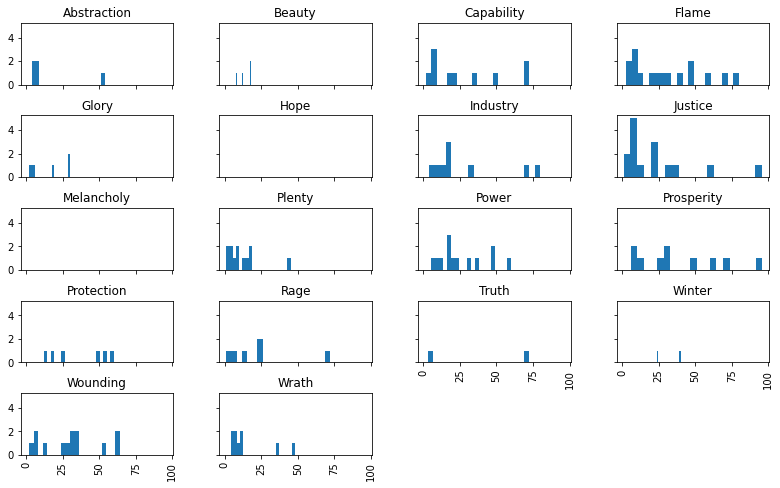

In [28]:
reds.hist(column="mana", by="enchant", figsize=(13,8), sharex=True, sharey=True, bins=20)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>]], dtype=object)

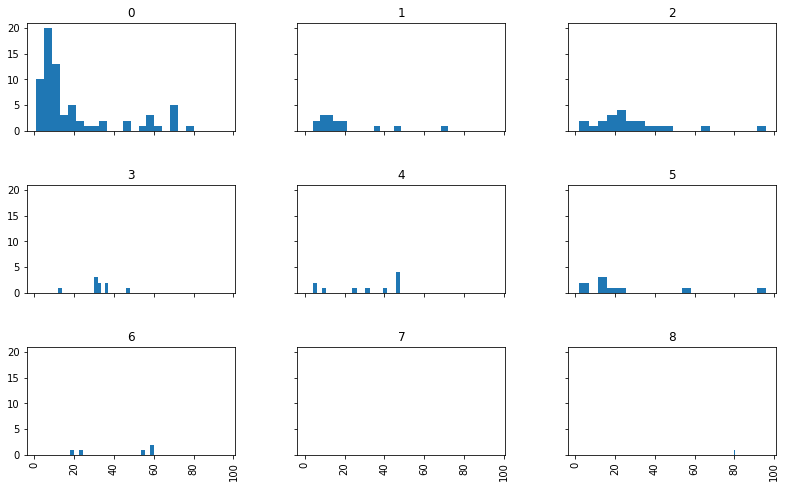

In [29]:
reds.hist(column="mana", by="mod", figsize=(13,8), sharex=True, sharey=True, bins=20)

In [30]:
greens = data[data["color"] == "green"]

array([[<AxesSubplot:title={'center':'Amulet'}>,
        <AxesSubplot:title={'center':'Axe'}>,
        <AxesSubplot:title={'center':'Battleaxe'}>],
       [<AxesSubplot:title={'center':'Hammer'}>,
        <AxesSubplot:title={'center':'Longsword'}>,
        <AxesSubplot:title={'center':'Pendant'}>],
       [<AxesSubplot:title={'center':'Plough'}>,
        <AxesSubplot:title={'center':'Ring'}>,
        <AxesSubplot:title={'center':'Saw'}>],
       [<AxesSubplot:title={'center':'Sword'}>,
        <AxesSubplot:title={'center':'Warhammer'}>, <AxesSubplot:>]],
      dtype=object)

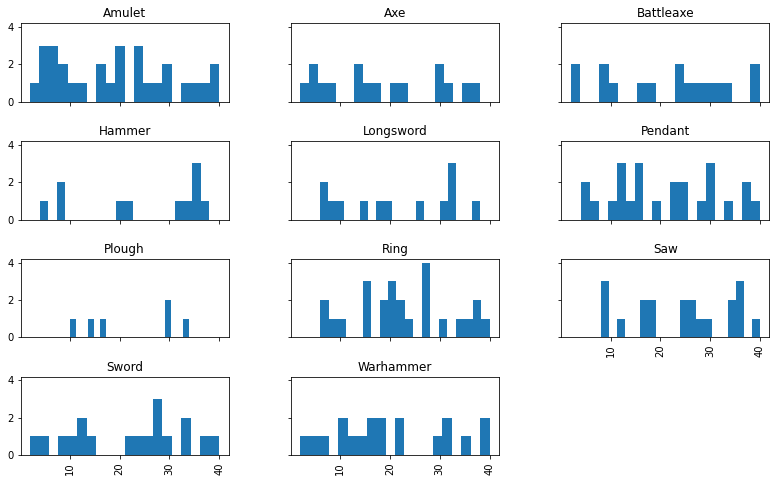

In [31]:
greens.hist(column="mana", by="item", figsize=(13,8), sharex=True, sharey=True, bins=20)

array([[<AxesSubplot:title={'center':'Abstraction'}>,
        <AxesSubplot:title={'center':'Beauty'}>,
        <AxesSubplot:title={'center':'Capability'}>,
        <AxesSubplot:title={'center':'Flame'}>],
       [<AxesSubplot:title={'center':'Glory'}>,
        <AxesSubplot:title={'center':'Hope'}>,
        <AxesSubplot:title={'center':'Industry'}>,
        <AxesSubplot:title={'center':'Joy'}>],
       [<AxesSubplot:title={'center':'Justice'}>,
        <AxesSubplot:title={'center':'Melancholy'}>,
        <AxesSubplot:title={'center':'Plenty'}>,
        <AxesSubplot:title={'center':'Power'}>],
       [<AxesSubplot:title={'center':'Prosperity'}>,
        <AxesSubplot:title={'center':'Protection'}>,
        <AxesSubplot:title={'center':'Rage'}>,
        <AxesSubplot:title={'center':'Truth'}>],
       [<AxesSubplot:title={'center':'Winter'}>,
        <AxesSubplot:title={'center':'Wounding'}>,
        <AxesSubplot:title={'center':'Wrath'}>, <AxesSubplot:>]],
      dtype=object)

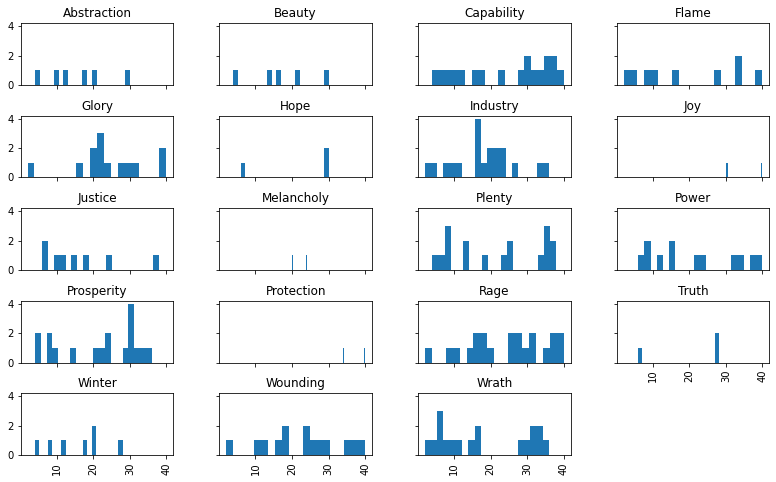

In [32]:
greens.hist(column="mana", by="enchant", figsize=(13,8), sharex=True, sharey=True, bins=20)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

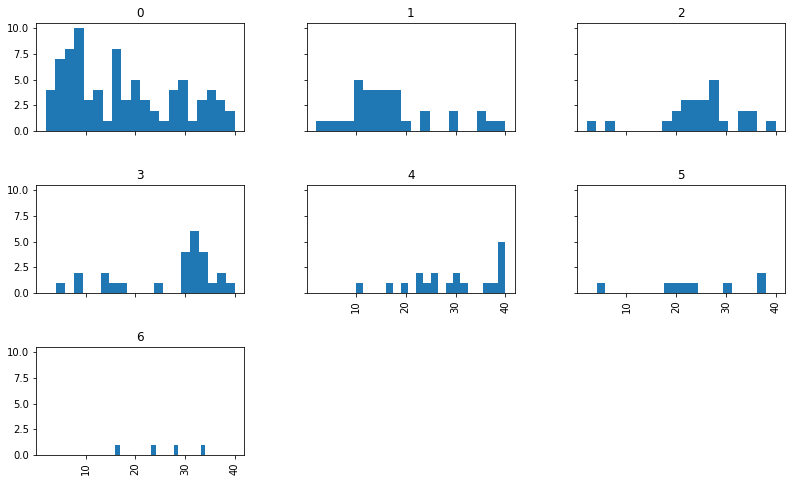

In [33]:
greens.hist(column="mana", by="mod", figsize=(13,8), sharex=True, sharey=True, bins=20)

Ok, finally. It looks like higher modifiers here are better, by a bit.

In [34]:
greens.groupby("mod")["mana"].describe()

,count,mean,std,min,25%,50%,75%,max
mod,,,,,,,,
0,81.0,17.432099,11.542247,2.0,8.0,16.0,28.0,40.0
1,34.0,17.294118,9.721982,2.0,10.5,15.0,19.5,40.0
2,25.0,25.280000,8.463254,2.0,22.0,26.0,28.0,40.0
3,26.0,27.153846,10.340957,4.0,19.5,32.0,34.0,40.0
4,19.0,29.473684,9.112680,10.0,23.0,30.0,39.0,40.0
5,8.0,24.250000,11.234513,4.0,19.5,23.0,32.0,38.0
6,4.0,25.500000,7.549834,16.0,22.0,26.0,29.5,34.0


No modifier and +1 look the same to me, but mean jumps up on +2. It mostly seems to be driven by having less terrible (low 25%) artifacts.

In [35]:
greens.eval('himod = mod >= 2').groupby("himod")["mana"].describe()

,count,mean,std,min,25%,50%,75%,max
himod,,,,,,,,
False,115.0,17.391304,10.993376,2.0,8.0,16.0,25.0,40.0
True,82.0,26.756098,9.426206,2.0,22.0,28.0,34.0,40.0


array([[<AxesSubplot:title={'center':'mana'}>]], dtype=object)

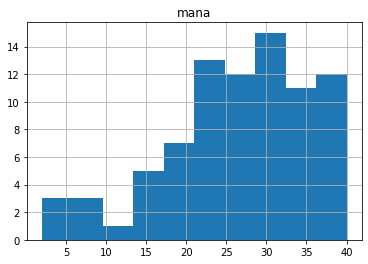

In [36]:
greens[greens["mod"] >= 2].hist(column="mana")

array([[<AxesSubplot:title={'center':'mana'}>]], dtype=object)

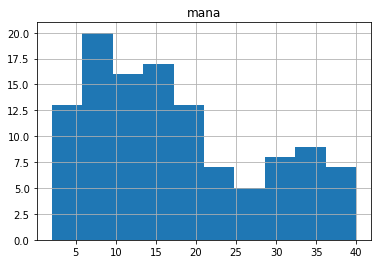

In [37]:
greens[greens["mod"] < 2].hist(column="mana")

I didn't see a mod-mana relationship in the reds histograms, but now I have a reason to look more closely

In [38]:
reds.eval('himod = mod >= 2').groupby("himod")["mana"].describe()

,count,mean,std,min,25%,50%,75%,max
himod,,,,,,,,
False,85.0,20.482353,21.764766,1.0,6.0,12.0,24.0,80.0
True,56.0,32.303571,21.934547,2.0,17.5,30.0,48.0,96.0


array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

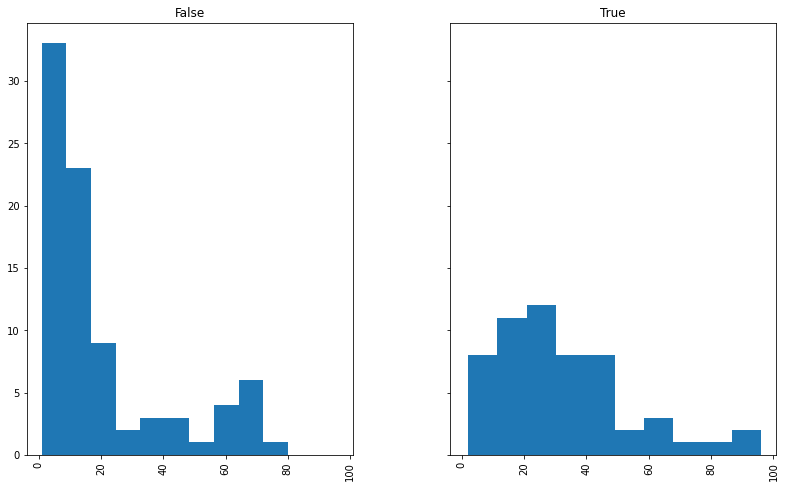

In [39]:
reds.eval('himod = mod >= 2').hist(column="mana", by="himod", sharex=True, sharey=True, figsize=(13,8))

That is a pretty big jump in mana values and just like in the greens, it seems to be driven by terrible items being way more common in the +0/+1 bracket.